In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3777 - acc: 0.3264
Epoch 00001: val_loss improved from inf to 1.70210, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_3_conv_checkpoint/001-1.7021.hdf5
36805/36805 [==============================] - 31s 841us/sample - loss: 2.3768 - acc: 0.3265 - val_loss: 1.7021 - val_acc: 0.4305
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5551 - acc: 0.5193
Epoch 00002: val_loss improved from 1.70210 to 1.50501, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_3_conv_checkpoint/002-1.5050.hdf5
36805/36805 [==============================] - 28s 758us/sample - loss: 1.5554 - acc: 0.5192 - val_loss: 1.5050 - val_acc: 0.5257
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.2680 - acc: 0.6000
Epoch 00003: val_loss improved 

Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1968 - acc: 0.9361
Epoch 00028: val_loss did not improve from 1.23915
36805/36805 [==============================] - 28s 760us/sample - loss: 0.1972 - acc: 0.9359 - val_loss: 1.9064 - val_acc: 0.6184
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9329
Epoch 00029: val_loss did not improve from 1.23915
36805/36805 [==============================] - 28s 755us/sample - loss: 0.1976 - acc: 0.9330 - val_loss: 1.5489 - val_acc: 0.6613
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1866 - acc: 0.9380
Epoch 00030: val_loss did not improve from 1.23915
36805/36805 [==============================] - 28s 759us/sample - loss: 0.1865 - acc: 0.9380 - val_loss: 1.7770 - val_acc: 0.6348
Epoch 31/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9435
Epoch 00031: val_loss did not improve from 1.23915
36805/36805 [=====

Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9713
Epoch 00058: val_loss did not improve from 1.23915
36805/36805 [==============================] - 28s 762us/sample - loss: 0.0910 - acc: 0.9713 - val_loss: 1.9585 - val_acc: 0.6466

1D_CNN_custom_multi_2_concat_ch_32_DO_BN_3_conv Model


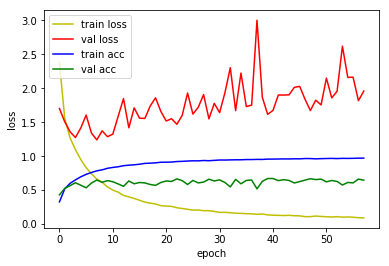

4815/4815 [==============================] - 2s 370us/sample - loss: 1.3305 - acc: 0.6191
Loss: 1.3304850657285807 Accuracy: 0.61910695

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3246 - acc: 0.3160
Epoch 00001: val_loss improved from inf to 1.76226, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_4_conv_checkpoint/001-1.7623.hdf5
36805/36805 [==============================] - 32s 877us/sample - loss: 2.3245 - acc: 0.3160 - val_loss: 1.7623 - val_acc: 0.4074
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5547 - acc: 0.5122
Epoch 00002: val_loss improved from 1.76226 to 1.25202, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_4_conv_checkpoint/002-1.2520.hdf5
36805/36805 [==============================] - 28s 774us/sample - loss: 1.5548 - acc: 0.5122 - val_loss: 1.2520 - val_acc: 0.6012
Epoch 3/500
36736/36805 [=============

36736/36805 [============================>.] - ETA: 0s - loss: 0.3831 - acc: 0.8752
Epoch 00027: val_loss did not improve from 0.85901
36805/36805 [==============================] - 28s 769us/sample - loss: 0.3833 - acc: 0.8752 - val_loss: 0.9907 - val_acc: 0.7391
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3691 - acc: 0.8783
Epoch 00028: val_loss did not improve from 0.85901
36805/36805 [==============================] - 28s 769us/sample - loss: 0.3691 - acc: 0.8783 - val_loss: 1.1263 - val_acc: 0.7186
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3644 - acc: 0.8820
Epoch 00029: val_loss did not improve from 0.85901
36805/36805 [==============================] - 28s 767us/sample - loss: 0.3647 - acc: 0.8817 - val_loss: 1.0848 - val_acc: 0.7084
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3436 - acc: 0.8890
Epoch 00030: val_loss did not improve from 0.85901
36805/36805 [==================

36736/36805 [============================>.] - ETA: 0s - loss: 0.2061 - acc: 0.9324
Epoch 00056: val_loss did not improve from 0.84421
36805/36805 [==============================] - 28s 770us/sample - loss: 0.2060 - acc: 0.9324 - val_loss: 1.0065 - val_acc: 0.7715
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9361
Epoch 00057: val_loss did not improve from 0.84421
36805/36805 [==============================] - 28s 772us/sample - loss: 0.1982 - acc: 0.9361 - val_loss: 0.9324 - val_acc: 0.7782
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1990 - acc: 0.9343
Epoch 00058: val_loss did not improve from 0.84421
36805/36805 [==============================] - 29s 775us/sample - loss: 0.1990 - acc: 0.9343 - val_loss: 1.1510 - val_acc: 0.7261
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9346
Epoch 00059: val_loss did not improve from 0.84421
36805/36805 [==================

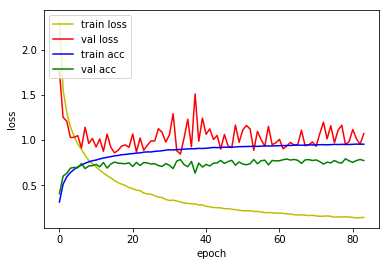

4815/4815 [==============================] - 2s 397us/sample - loss: 0.9603 - acc: 0.7400
Loss: 0.9603418133340521 Accuracy: 0.7399792

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3778 - acc: 0.2944
Epoch 00001: val_loss improved from inf to 1.68693, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/001-1.6869.hdf5
36805/36805 [==============================] - 36s 973us/sample - loss: 2.3776 - acc: 0.2944 - val_loss: 1.6869 - val_acc: 0.4284
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5755 - acc: 0.5011
Epoch 00002: val_loss improved from 1.68693 to 1.21004, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/002-1.2100.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 1.5757 - acc: 0.5011 - val_loss: 1.2100 - val_acc: 0.6343
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.4772 - acc: 0.8529
Epoch 00024: val_loss improved from 0.59887 to 0.54986, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/024-0.5499.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.4772 - acc: 0.8528 - val_loss: 0.5499 - val_acc: 0.8495
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4553 - acc: 0.8611
Epoch 00025: val_loss did not improve from 0.54986
36805/36805 [==============================] - 30s 806us/sample - loss: 0.4553 - acc: 0.8612 - val_loss: 0.6194 - val_acc: 0.8255
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4464 - acc: 0.8631
Epoch 00026: val_loss improved from 0.54986 to 0.53489, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/026-0.5349.hdf5
36805/36805 [==============================] - 30s 812us/sample - loss: 0.4464 - ac

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2807 - acc: 0.9114
Epoch 00051: val_loss did not improve from 0.49738
36805/36805 [==============================] - 29s 800us/sample - loss: 0.2807 - acc: 0.9114 - val_loss: 0.5221 - val_acc: 0.8579
Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2785 - acc: 0.9122
Epoch 00052: val_loss improved from 0.49738 to 0.48863, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/052-0.4886.hdf5
36805/36805 [==============================] - 30s 808us/sample - loss: 0.2785 - acc: 0.9121 - val_loss: 0.4886 - val_acc: 0.8672
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.9127
Epoch 00053: val_loss did not improve from 0.48863
36805/36805 [==============================] - 30s 806us/sample - loss: 0.2788 - acc: 0.9127 - val_loss: 0.5018 - val_acc: 0.8696
Epoch 54/500
36736/36805 [===========================

36736/36805 [============================>.] - ETA: 0s - loss: 0.1987 - acc: 0.9363
Epoch 00079: val_loss improved from 0.46546 to 0.46526, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv_checkpoint/079-0.4653.hdf5
36805/36805 [==============================] - 30s 807us/sample - loss: 0.1988 - acc: 0.9363 - val_loss: 0.4653 - val_acc: 0.8772
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9356
Epoch 00080: val_loss did not improve from 0.46526
36805/36805 [==============================] - 30s 808us/sample - loss: 0.1972 - acc: 0.9356 - val_loss: 0.4727 - val_acc: 0.8800
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9376
Epoch 00081: val_loss did not improve from 0.46526
36805/36805 [==============================] - 30s 810us/sample - loss: 0.1924 - acc: 0.9376 - val_loss: 0.5372 - val_acc: 0.8628
Epoch 82/500
36800/36805 [============================>.] - ETA: 0

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9514
Epoch 00107: val_loss did not improve from 0.44513
36805/36805 [==============================] - 30s 802us/sample - loss: 0.1536 - acc: 0.9513 - val_loss: 0.5262 - val_acc: 0.8733
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.9501
Epoch 00108: val_loss did not improve from 0.44513
36805/36805 [==============================] - 30s 803us/sample - loss: 0.1525 - acc: 0.9501 - val_loss: 0.4729 - val_acc: 0.8847
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9516
Epoch 00109: val_loss did not improve from 0.44513
36805/36805 [==============================] - 29s 799us/sample - loss: 0.1526 - acc: 0.9516 - val_loss: 0.4877 - val_acc: 0.8786
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1482 - acc: 0.9519
Epoch 00110: val_loss did not improve from 0.44513
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9604
Epoch 00136: val_loss did not improve from 0.44513
36805/36805 [==============================] - 30s 816us/sample - loss: 0.1239 - acc: 0.9603 - val_loss: 0.4652 - val_acc: 0.8949
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1271 - acc: 0.9586
Epoch 00137: val_loss did not improve from 0.44513
36805/36805 [==============================] - 30s 816us/sample - loss: 0.1271 - acc: 0.9586 - val_loss: 0.5054 - val_acc: 0.8826
Epoch 138/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1228 - acc: 0.9595
Epoch 00138: val_loss did not improve from 0.44513
36805/36805 [==============================] - 30s 811us/sample - loss: 0.1228 - acc: 0.9595 - val_loss: 0.5010 - val_acc: 0.8854
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9604
Epoch 00139: val_loss did not improve from 0.44513
36805/36805 [===============

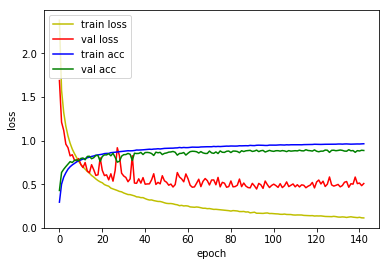

4815/4815 [==============================] - 2s 447us/sample - loss: 0.5140 - acc: 0.8602
Loss: 0.5140387244375572 Accuracy: 0.8602285

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4624 - acc: 0.2623
Epoch 00001: val_loss improved from inf to 1.67634, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_6_conv_checkpoint/001-1.6763.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 2.4622 - acc: 0.2624 - val_loss: 1.6763 - val_acc: 0.4549
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6107 - acc: 0.4836
Epoch 00002: val_loss improved from 1.67634 to 1.12438, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_6_conv_checkpoint/002-1.1244.hdf5
36805/36805 [==============================] - 31s 851us/sample - loss: 1.6107 - acc: 0.4836 - val_loss: 1.1244 - val_acc: 0.6490
Epoch 3/500
36800/36805 [================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3257 - acc: 0.9000
Epoch 00024: val_loss did not improve from 0.30885
36805/36805 [==============================] - 31s 842us/sample - loss: 0.3260 - acc: 0.8999 - val_loss: 0.3769 - val_acc: 0.8910
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3278 - acc: 0.8985
Epoch 00025: val_loss did not improve from 0.30885
36805/36805 [==============================] - 31s 842us/sample - loss: 0.3279 - acc: 0.8984 - val_loss: 0.3354 - val_acc: 0.9038
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3067 - acc: 0.9059
Epoch 00026: val_loss improved from 0.30885 to 0.29065, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_6_conv_checkpoint/026-0.2907.hdf5
36805/36805 [==============================] - 31s 844us/sample - loss: 0.3067 - acc: 0.9059 - val_loss: 0.2907 - val_acc: 0.9187
Epoch 27/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1804 - acc: 0.9430
Epoch 00050: val_loss did not improve from 0.24318
36805/36805 [==============================] - 31s 847us/sample - loss: 0.1805 - acc: 0.9430 - val_loss: 0.2888 - val_acc: 0.9236
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1748 - acc: 0.9446
Epoch 00051: val_loss improved from 0.24318 to 0.24123, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_6_conv_checkpoint/051-0.2412.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 0.1747 - acc: 0.9446 - val_loss: 0.2412 - val_acc: 0.9327
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9441
Epoch 00052: val_loss did not improve from 0.24123
36805/36805 [==============================] - 31s 843us/sample - loss: 0.1732 - acc: 0.9441 - val_loss: 0.2558 - val_acc: 0.9285
Epoch 53/500
36800/36805 [============================>.] - ETA: 0

Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9611
Epoch 00079: val_loss did not improve from 0.22915
36805/36805 [==============================] - 31s 842us/sample - loss: 0.1189 - acc: 0.9611 - val_loss: 0.3122 - val_acc: 0.9182
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9619
Epoch 00080: val_loss did not improve from 0.22915
36805/36805 [==============================] - 31s 843us/sample - loss: 0.1181 - acc: 0.9619 - val_loss: 0.2574 - val_acc: 0.9276
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1131 - acc: 0.9634
Epoch 00081: val_loss did not improve from 0.22915
36805/36805 [==============================] - 31s 846us/sample - loss: 0.1131 - acc: 0.9634 - val_loss: 0.2333 - val_acc: 0.9378
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9620
Epoch 00082: val_loss did not improve from 0.22915
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9704
Epoch 00108: val_loss did not improve from 0.22214
36805/36805 [==============================] - 31s 837us/sample - loss: 0.0897 - acc: 0.9704 - val_loss: 0.2402 - val_acc: 0.9408
Epoch 109/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0877 - acc: 0.9721
Epoch 00109: val_loss did not improve from 0.22214
36805/36805 [==============================] - 31s 836us/sample - loss: 0.0877 - acc: 0.9721 - val_loss: 0.2512 - val_acc: 0.9373
Epoch 110/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0825 - acc: 0.9734
Epoch 00110: val_loss did not improve from 0.22214
36805/36805 [==============================] - 31s 836us/sample - loss: 0.0825 - acc: 0.9735 - val_loss: 0.2349 - val_acc: 0.9425
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9721
Epoch 00111: val_loss did not improve from 0.22214
36805/36805 [=

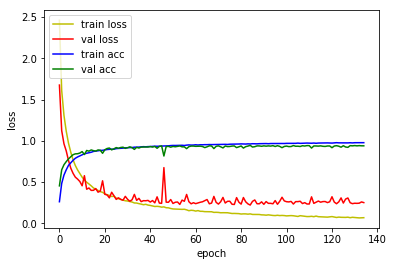

4815/4815 [==============================] - 2s 449us/sample - loss: 0.2756 - acc: 0.9238
Loss: 0.27560059349608695 Accuracy: 0.92377985

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6621 - acc: 0.2207
Epoch 00001: val_loss improved from inf to 1.84711, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv_checkpoint/001-1.8471.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.6620 - acc: 0.2207 - val_loss: 1.8471 - val_acc: 0.4284
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6897 - acc: 0.4552
Epoch 00002: val_loss improved from 1.84711 to 1.16154, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv_checkpoint/002-1.1615.hdf5
36805/36805 [==============================] - 32s 879us/sample - loss: 1.6896 - acc: 0.4552 - val_loss: 1.1615 - val_acc: 0.6497
Epoch 3/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9274
Epoch 00023: val_loss improved from 0.21571 to 0.21395, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv_checkpoint/023-0.2139.hdf5
36805/36805 [==============================] - 32s 879us/sample - loss: 0.2329 - acc: 0.9274 - val_loss: 0.2139 - val_acc: 0.9352
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9323
Epoch 00024: val_loss improved from 0.21395 to 0.19751, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv_checkpoint/024-0.1975.hdf5
36805/36805 [==============================] - 32s 876us/sample - loss: 0.2204 - acc: 0.9323 - val_loss: 0.1975 - val_acc: 0.9434
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9349
Epoch 00025: val_loss did not improve from 0.19751
36805/36805 [==============================] - 32s 869us/sample - loss: 0.2136 - ac

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1178 - acc: 0.9625
Epoch 00050: val_loss did not improve from 0.16095
36805/36805 [==============================] - 32s 875us/sample - loss: 0.1178 - acc: 0.9625 - val_loss: 0.1702 - val_acc: 0.9490
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1078 - acc: 0.9659
Epoch 00051: val_loss did not improve from 0.16095
36805/36805 [==============================] - 32s 875us/sample - loss: 0.1079 - acc: 0.9659 - val_loss: 0.1812 - val_acc: 0.9448
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1115 - acc: 0.9640
Epoch 00052: val_loss did not improve from 0.16095
36805/36805 [==============================] - 32s 875us/sample - loss: 0.1115 - acc: 0.9640 - val_loss: 0.1934 - val_acc: 0.9478
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9667
Epoch 00053: val_loss did not improve from 0.16095
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9780
Epoch 00078: val_loss did not improve from 0.15337
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0692 - acc: 0.9780 - val_loss: 0.2009 - val_acc: 0.9446
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9756
Epoch 00079: val_loss improved from 0.15337 to 0.14819, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv_checkpoint/079-0.1482.hdf5
36805/36805 [==============================] - 32s 882us/sample - loss: 0.0744 - acc: 0.9756 - val_loss: 0.1482 - val_acc: 0.9562
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9786
Epoch 00080: val_loss did not improve from 0.14819
36805/36805 [==============================] - 32s 874us/sample - loss: 0.0656 - acc: 0.9786 - val_loss: 0.1633 - val_acc: 0.9585
Epoch 81/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9860
Epoch 00107: val_loss did not improve from 0.14819
36805/36805 [==============================] - 31s 856us/sample - loss: 0.0436 - acc: 0.9860 - val_loss: 0.1790 - val_acc: 0.9522
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9826
Epoch 00108: val_loss did not improve from 0.14819
36805/36805 [==============================] - 32s 878us/sample - loss: 0.0513 - acc: 0.9826 - val_loss: 0.1739 - val_acc: 0.9553
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9855
Epoch 00109: val_loss did not improve from 0.14819
36805/36805 [==============================] - 32s 873us/sample - loss: 0.0462 - acc: 0.9855 - val_loss: 0.1759 - val_acc: 0.9529
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9825
Epoch 00110: val_loss did not improve from 0.14819
36805/36805 [===============

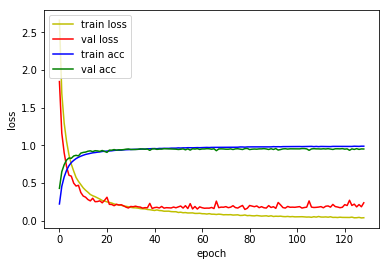

4815/4815 [==============================] - 2s 518us/sample - loss: 0.2017 - acc: 0.9379
Loss: 0.20172141901181617 Accuracy: 0.9379024

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7000 - acc: 0.2161
Epoch 00001: val_loss improved from inf to 1.82984, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_8_conv_checkpoint/001-1.8298.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.7001 - acc: 0.2161 - val_loss: 1.8298 - val_acc: 0.4430
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7009 - acc: 0.4497
Epoch 00002: val_loss improved from 1.82984 to 1.07609, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_8_conv_checkpoint/002-1.0761.hdf5
36805/36805 [==============================] - 34s 923us/sample - loss: 1.7009 - acc: 0.4497 - val_loss: 1.0761 - val_acc: 0.6746
Epoch 3/500
36800/36805 [===============

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1846 - acc: 0.9427
Epoch 00025: val_loss improved from 0.19432 to 0.19025, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_8_conv_checkpoint/025-0.1902.hdf5
36805/36805 [==============================] - 34s 929us/sample - loss: 0.1848 - acc: 0.9426 - val_loss: 0.1902 - val_acc: 0.9413
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1757 - acc: 0.9446
Epoch 00026: val_loss did not improve from 0.19025
36805/36805 [==============================] - 34s 919us/sample - loss: 0.1758 - acc: 0.9445 - val_loss: 0.1992 - val_acc: 0.9408
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1702 - acc: 0.9467
Epoch 00027: val_loss improved from 0.19025 to 0.18549, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_ch_32_DO_BN_8_conv_checkpoint/027-0.1855.hdf5
36805/36805 [==============================] - 34s 927us/sample - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.0846 - acc: 0.9722
Epoch 00052: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0846 - acc: 0.9722 - val_loss: 0.1789 - val_acc: 0.9474
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0801 - acc: 0.9737
Epoch 00053: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 924us/sample - loss: 0.0801 - acc: 0.9738 - val_loss: 0.1791 - val_acc: 0.9490
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9752
Epoch 00054: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 924us/sample - loss: 0.0760 - acc: 0.9752 - val_loss: 0.2223 - val_acc: 0.9359
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9757
Epoch 00055: val_loss did not improve from 0.15973
36805/36805 [==================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9845
Epoch 00082: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 918us/sample - loss: 0.0492 - acc: 0.9844 - val_loss: 0.1714 - val_acc: 0.9569
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9842
Epoch 00083: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 921us/sample - loss: 0.0485 - acc: 0.9842 - val_loss: 0.1901 - val_acc: 0.9513
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9873
Epoch 00084: val_loss did not improve from 0.15973
36805/36805 [==============================] - 34s 919us/sample - loss: 0.0412 - acc: 0.9873 - val_loss: 0.1859 - val_acc: 0.9546
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9850
Epoch 00085: val_loss did not improve from 0.15973
36805/36805 [=====

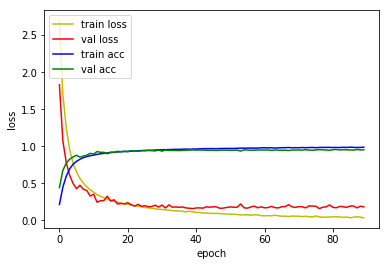

4815/4815 [==============================] - 3s 578us/sample - loss: 0.2084 - acc: 0.9394
Loss: 0.20844632921003478 Accuracy: 0.9393562



In [10]:
base = '1D_CNN_custom_multi_2_concat_ch_32_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
______________________________________________________

4815/4815 [==============================] - 3s 559us/sample - loss: 0.9603 - acc: 0.7400
Loss: 0.9603418133340521 Accuracy: 0.7399792

1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Act

4815/4815 [==============================] - 3s 571us/sample - loss: 0.2756 - acc: 0.9238
Loss: 0.27560059349608695 Accuracy: 0.92377985

1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (A

4815/4815 [==============================] - 3s 651us/sample - loss: 0.2084 - acc: 0.9394
Loss: 0.20844632921003478 Accuracy: 0.9393562


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_concat_ch_32_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_33[0][0]  
______________________________________________________

4815/4815 [==============================] - 3s 628us/sample - loss: 1.1917 - acc: 0.7333
Loss: 1.1917428730432862 Accuracy: 0.73333335

1D_CNN_custom_multi_2_concat_ch_32_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Ac

4815/4815 [==============================] - 4s 745us/sample - loss: 0.2780 - acc: 0.9265
Loss: 0.27802235705706435 Accuracy: 0.92647976

1D_CNN_custom_multi_2_concat_ch_32_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (A

4815/4815 [==============================] - 4s 732us/sample - loss: 0.2371 - acc: 0.9410
Loss: 0.2370868181451954 Accuracy: 0.9410176
